In [1]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from collections import OrderedDict

In [2]:
from platform import python_version
print(python_version())

3.6.6


### Create edgelist using events data

In [3]:
event_file = [item for item in os.listdir('../../data/protag_events/') if 'txt' in item]

In [7]:
events_all = []
cnt = 0
for name in event_file:
    movie_events = []
    with open(os.path.join('../../data/protag_events/', name), 'r') as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            print(line)
        print()
        cnt += 1
        if cnt == 20:
            break
#         lines = list(dict.fromkeys(lines)) # Remove duplicates
#         for line in lines:
#             line = line.split(' ')
#             line[0] = 'protagonist'
#             line = ' '.join([item for item in line[0:2]])
#             movie_events.append(line)
#         events_all.append(movie_events)


they base-97.1 EmptyParameter EmptyParameter
they appear-48.1.1 EmptyParameter EmptyParameter
they steal-10.5-1 MISC Synset('display.n.06')
they escape-51.1-1 EmptyParameter Synset('elevator.n.01')
they escape-51.1-1 EmptyParameter Synset('roof.n.01')
they get-13.5.1 EmptyParameter <NE>0
they other_cos-45.4 everything EmptyParameter
they obtain-13.5.2 EmptyParameter EmptyParameter

Tetsu escape-51.1 obtain-13.5.2 EmptyParameter
Tetsu obtain-13.5.2 Synset('bicycle.n.01') EmptyParameter
Tetsu neglect-75-2 fend EmptyParameter
Tetsu fend Synset('attack.n.08') EmptyParameter
Tetsu contiguous_location-47.8-1 shū EmptyParameter
Tetsu battle-36.4-1 EmptyParameter EmptyParameter
Tetsu appear-48.1.1 EmptyParameter EmptyParameter
Tetsu escape-51.1 EmptyParameter EmptyParameter
Tetsu cope-83-1-1 amuse-31.1 EmptyParameter
Tetsu seem-109-1-1 EmptyParameter EmptyParameter
Tetsu exchange-13.6-1 Synset('supreme_headquarters_allied_powers_europe.n.01') EmptyParameter
Tetsu enforce-63 Synset('creature.n.

In [7]:
len(events_all)

15179

In [8]:
events_all[0:2]

[['protagonist base-97.1',
  'protagonist appear-48.1.1',
  'protagonist steal-10.5-1',
  'protagonist escape-51.1-1',
  'protagonist escape-51.1-1',
  'protagonist get-13.5.1',
  'protagonist other_cos-45.4',
  'protagonist obtain-13.5.2'],
 ['protagonist escape-51.1',
  'protagonist obtain-13.5.2',
  'protagonist neglect-75-2',
  'protagonist fend',
  'protagonist contiguous_location-47.8-1',
  'protagonist battle-36.4-1',
  'protagonist appear-48.1.1',
  'protagonist escape-51.1',
  'protagonist cope-83-1-1',
  'protagonist seem-109-1-1',
  'protagonist exchange-13.6-1',
  'protagonist enforce-63',
  'protagonist dub-29.3']]

In [9]:
edgelist = []
for movie_event in events_all:
    for i in range(len(movie_event)-1):
        edgelist.append((movie_event[i], movie_event[i+1]))

In [10]:
c = Counter(edgelist)

In [11]:
c.most_common(20)

[(('protagonist amuse-31.1', 'protagonist amuse-31.1'), 809),
 (('protagonist get-13.5.1', 'protagonist get-13.5.1'), 534),
 (('protagonist amuse-31.1', 'protagonist get-13.5.1'), 404),
 (('protagonist own-100', 'protagonist own-100'), 394),
 (('protagonist get-13.5.1', 'protagonist amuse-31.1'), 392),
 (('protagonist get-13.5.1', 'protagonist discover-84'), 356),
 (('protagonist escape-51.1', 'protagonist get-13.5.1'), 317),
 (('protagonist meander-47.7', 'protagonist get-13.5.1'), 306),
 (('protagonist discover-84', 'protagonist get-13.5.1'), 302),
 (('protagonist discover-84', 'protagonist amuse-31.1'), 295),
 (('protagonist escape-51.1', 'protagonist amuse-31.1'), 291),
 (('protagonist amuse-31.1', 'protagonist meander-47.7'), 286),
 (('protagonist amuse-31.1', 'protagonist discover-84'), 270),
 (('protagonist discover-84', 'protagonist discover-84'), 259),
 (('protagonist own-100', 'protagonist amuse-31.1'), 252),
 (('protagonist meander-47.7', 'protagonist amuse-31.1'), 251),
 ((

In [12]:
edgelist_wtd = []
for item in edgelist:
    if c[item] > 1:
        edge = (item[0], item[1], c[item])
        edgelist_wtd.append(edge)

In [13]:
edgelist_wtd[0:5]

[('protagonist appear-48.1.1', 'protagonist steal-10.5-1', 25),
 ('protagonist steal-10.5-1', 'protagonist escape-51.1-1', 23),
 ('protagonist escape-51.1-1', 'protagonist escape-51.1-1', 90),
 ('protagonist escape-51.1-1', 'protagonist get-13.5.1', 127),
 ('protagonist get-13.5.1', 'protagonist other_cos-45.4', 134)]

### Build network

In [14]:
G = nx.DiGraph()

In [15]:
G.add_weighted_edges_from(edgelist_wtd)

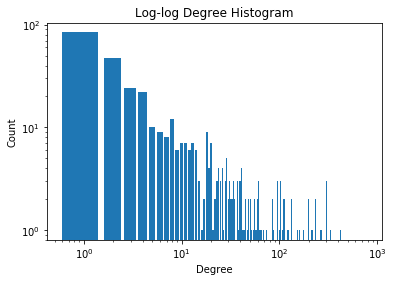

In [16]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt)

plt.title("Log-log Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xscale('log')
plt.yscale('log')
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

In [17]:
nx.write_gml(G, 'event_network.gml')